In [1]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt

import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [ ]:
import sys
import subprocess
import time
from datetime import datetime, timezone
from pathlib import Path
from glob import glob

import numpy as np
import xarray as xr
import pandas as pd


def read_mmclx_save_nc(mmclx_filename, nc_filename):
    """
    - Reading mmclx file with xarray
    - Extracting/modifying variables
    - Saving as NetCDF .nc file
    """

    # Open .mmclx file
    mmclx = xr.open_dataset(mmclx_filename)

    # Create .nc file with necessary variables
    ncfile = mmclx[
        [
            "Ze",
            "VEL",
            "LDR",
            "RHO",
            "DPS",
            "NyquistVelocity",
            "nave",
            "nfft",
            "prf",
            "zrg",
            "drg",
        ]
    ]
    # Invert order of dimensions
    ncfile = ncfile.transpose()

    # Convert + change attributes of time dimension
    ncfile["time"] = (
        "time",
        pd.to_datetime(ncfile.time.values, unit="s"),
        {"long_name": "Time in epoch reference", "standard_name": "time"},
    )
    # Change attributes of range dimension
    ncfile["range"] = ncfile.range.assign_attrs(
        {
            "long_name": "Range from antenna to the centre of each range gate",
            "standard_name": "range",
        }
    )

    # Create additional instrument parameters
    ncfile["pulse_width"] = float(
        ncfile.hrd[
            (ncfile.hrd.find("\nPULSE_WIDTH:") + 15) : ncfile.hrd.find(
                "\nRX_PULSEWIDTH:"
            )
        ]
    )
    ncfile["pulse_width"] = ncfile.pulse_width.assign_attrs(
        {
            "long_name": "Pulse Width",
            "units": "s",
            "meta_group": "instrument_parameters",
            "standard_name": "hrd['PULSE_WIDTH']",
        }
    )
    ncfile["prt"] = 2e-4
    ncfile["prt"] = ncfile.prt.assign_attrs(
        {
            "long_name": "Pulse repetition time",
            "units": "s",
            "meta_group": "instrument_parameters",
            "standard_name": "",
        }
    )
    ncfile["frequency"] = 35e9
    ncfile["frequency"] = ncfile.frequency.assign_attrs(
        {
            "long_name": "Radiation Frequency",
            "units": "s^-1",
            "meta_group": "instrument_parameters",
            "standard_name": "",
        }
    )
    ncfile["latitude"] = float(ncfile.Latitude[:-1])
    ncfile["latitude"] = ncfile.latitude.assign_attrs(
        {
            "long_name": "Latitude",
            "units": "degrees_north",
            "meta_group": "instrument_parameters",
            "standard_name": "Latitude",
        }
    )
    ncfile["longitude"] = float(ncfile.Longitude[:-1])
    ncfile["longitude"] = ncfile.longitude.assign_attrs(
        {
            "long_name": "Longitude",
            "units": "degrees_east",
            "meta_group": "instrument_parameters",
            "standard_name": "Longitude",
        }
    )
    ncfile["altitude"] = float(ncfile.Altitude[:-1])
    ncfile["altitude"] = ncfile.altitude.assign_attrs(
        {
            "long_name": "Altitude",
            "units": "m",
            "meta_group": "instrument_parameters",
            "standard_name": "Altitude",
        }
    )

    # Change names of variables
    ncfile = ncfile.rename_vars(
        {
            "Ze": "filtered_reflectivity",
            "VEL": "filtered_velocity",
            "LDR": "filtered_linear_depolarization_ratio",
            "RHO": "cross_correlation_ratio",
            "DPS": "differential_phase",
            "NyquistVelocity": "nyquist_velocity",
            "nave": "n_samples",
            "nfft": "n_fft",
            "zrg": "n_range_gates",
            "drg": "range_resolution",
        }
    )
    
    # Convert dBZ variables to dBZ
    ncfile.filtered_reflectivity.values = 10 * np.log10(
        ncfile.filtered_reflectivity.values
    )
    ncfile.filtered_linear_depolarization_ratio.values = 10 * np.log10(
        ncfile.filtered_linear_depolarization_ratio.values
    )

    # Change attributes of variables
    ncfile["filtered_reflectivity"] = ncfile.filtered_reflectivity.assign_attrs(
        {
            "units": "dBZ",
            "valid_range": ncfile.filtered_reflectivity.attrs.pop("yrange"),
            "standard_name": "Ze",
            "long_name": "Filtered Equivalent Reflectivity Factor",
        }
    )
    ncfile["filtered_velocity"] = ncfile.filtered_velocity.assign_attrs(
        {
            "units": "m * s^-1",
            "valid_range": ncfile.filtered_velocity.attrs.pop("yrange"),
            "standard_name": "VEL",
            "long_name": "Filtered Mean Doppler Velocity",
        }
    )
    ncfile[
        "filtered_linear_depolarization_ratio"
    ] = ncfile.filtered_linear_depolarization_ratio.assign_attrs(
        {
            "units": "dB",
            "valid_range": ncfile.filtered_linear_depolarization_ratio.attrs.pop(
                "yrange"
            ),
            "standard_name": "LDR",
            "long_name": "Filtered Linear De-Polarization Ratio",
        }
    )
    ncfile[
        "cross_correlation_ratio"
    ] = ncfile.cross_correlation_ratio.assign_attrs(
        {
            "units": "unitless",
            "valid_range": ncfile.cross_correlation_ratio.attrs.pop("yrange"),
            "standard_name": "RHO",
            "long_name": "Co-Cross Correlation Ratio",
        }
    )
    ncfile["differential_phase"] = ncfile.differential_phase.assign_attrs(
        {
            "units": "degrees",
            "valid_range": ncfile.differential_phase.attrs.pop("yrange"),
            "standard_name": "DPS",
            "long_name": "Differential Phase",
        }
    )
    ncfile["nyquist_velocity"] = ncfile.nyquist_velocity.assign_attrs(
        {
            "units": "m * s^-1",
            "meta_group": "instrument_parameters",
            "standard_name": "NyquistVelocity",
            "long_name": "Nyquist Velocity",
        }
    )
    ncfile["n_samples"] = ncfile.n_samples.assign_attrs(
        {
            "units": "unitless",
            "meta_group": "instrument_parameters",
            "standard_name": "nave",
            "long_name": "Number of spectral averages used to compute moments",
        }
    )
    ncfile["n_fft"] = ncfile.n_fft.assign_attrs(
        {
            "units": "unitless",
            "meta_group": "instrument_parameters",
            "standard_name": "nfft",
            "long_name": "Number of FFT points",
        }
    )
    ncfile["prf"] = ncfile.prf.assign_attrs(
        {
            "units": "Hz",
            "meta_group": "instrument_parameters",
            "standard_name": "prf",
            "long_name": "Pulse Repetition Frequency",
        }
    )
    ncfile["n_range_gates"] = ncfile.n_range_gates.assign_attrs(
        {
            "units": "unitless",
            "meta_group": "instrument_parameters",
            "standard_name": "zrg",
            "long_name": "Number of range gates",
        }
    )
    ncfile["range_resolution"] = ncfile.range_resolution.assign_attrs(
        {
            "units": "m",
            "meta_group": "instrument_parameters",
            "standard_name": "drg",
            "long_name": "Range resolution",
        }
    )

    # Remove unnecessary attributes of variables
    for var in ncfile.variables:
        for attr in ["axis", "db", "unit"]:
            if attr in ncfile[var].attrs.keys():
                del ncfile[var].attrs[attr]

    # Remove unnecessary global attributes
    for attr in ["Altitude", "Latitude", "Longitude", "ppar", "hrd"]:
        del ncfile.attrs[attr]

    # Reorder variables
    ncfile = ncfile[
        [
            "filtered_reflectivity",
            "filtered_velocity",
            "filtered_linear_depolarization_ratio",
            "cross_correlation_ratio",
            "differential_phase",
            "nyquist_velocity",
            "n_fft",
            "prf",
            "prt",
            "n_range_gates",
            "range_resolution",
            "n_samples",
            "pulse_width",
            "frequency",
            "latitude",
            "longitude",
            "altitude",
        ]
    ]

    # Save .nc file
    ncfile.to_netcdf(
        nc_filename,
        unlimited_dims="time",
        encoding={"time": {"units": "seconds since 1970-01-01 00:00:00"}},
    )

In [ ]:
read_mmclx_save_nc('/data2/ATTO-Campina/mira_35c/2021/03/02/20210302_0300.mmclx', '/data2/ATTO-Campina/mira_35c/2021/03/02/20210302_0300.nc')

In [2]:
def preprocess(df):
    return df.sortby('time').filtered_reflectivity.resample(time='12H').max()

In [3]:
data = glob("/data2/ATTO-Campina/mira_35c/2023/*/*/*.nc")
mira = xr.open_mfdataset(data, combine='nested', concat_dim='time', preprocess=preprocess)

(0.0, 18000.0)

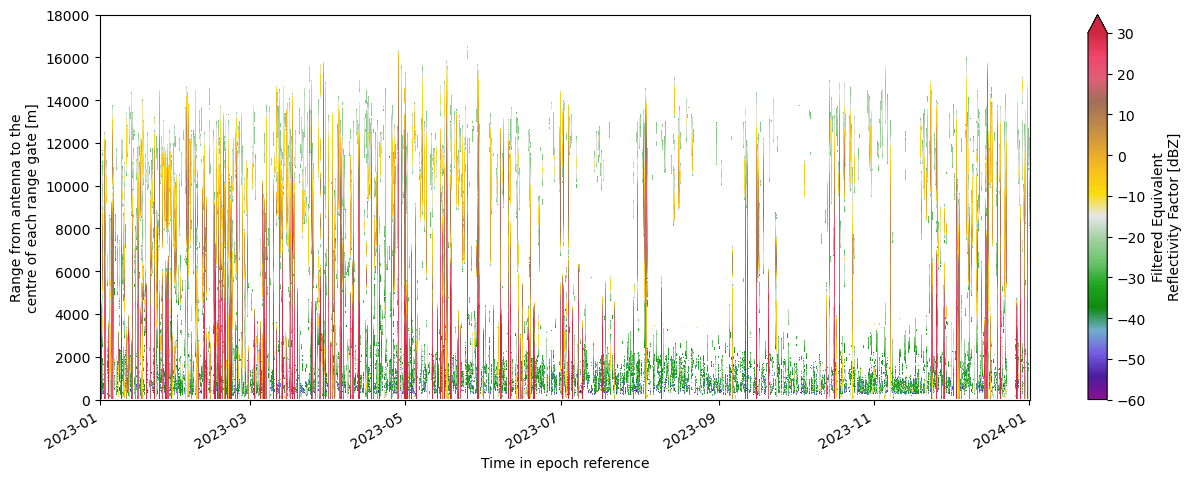

In [4]:
fig = plt.figure(figsize=(15, 5))
mira.sortby('time').plot(vmin=-60, vmax=30, cmap=pyart.graph.cm.Carbone17)
plt.ylim((0, 18000))